# 03 - NSD Stimulus Packaging

Extract the 515 shared stimulus images from `nsd_stimuli.hdf5` and save as individual PNGs
for Brain-Score stimulus set packaging.

In [1]:
import h5py
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
from tqdm.auto import tqdm

NSD_ROOT = Path('/Volumes/Hagibis/nsd')
STIMULI_HDF5 = NSD_ROOT / 'stimuli' / 'nsd_stimuli.hdf5'
SPLIT_CSV = NSD_ROOT / 'assemblies' / 'train_test_split.csv'
OUTPUT_DIR = NSD_ROOT / 'stimuli' / 'images'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

split_df = pd.read_csv(SPLIT_CSV)
print(f'Total stimuli: {len(split_df)}')
print(f'Train: {(split_df["split"] == "train").sum()}, Test: {(split_df["split"] == "test").sum()}')
split_df.head()

Total stimuli: 515
Train: 412, Test: 103


  stimulus_id  nsd_id  split
0   nsd_03049    3049  train
1   nsd_03077    3077   test
2   nsd_03157    3157  train
3   nsd_03164    3164  train
4   nsd_03171    3171  train

In [2]:
# Extract images from HDF5 and save as PNGs
nsd_ids = split_df['nsd_id'].values

with h5py.File(STIMULI_HDF5, 'r') as f:
    img_brick = f['imgBrick']
    print(f'imgBrick shape: {img_brick.shape}, dtype: {img_brick.dtype}')
    
    for nsd_id in tqdm(nsd_ids, desc='Extracting images'):
        img_array = img_brick[nsd_id]  # (425, 425, 3) uint8
        img = Image.fromarray(img_array, 'RGB')
        out_path = OUTPUT_DIR / f'nsd_{nsd_id:05d}.png'
        img.save(out_path)

print(f'Saved {len(nsd_ids)} images to {OUTPUT_DIR}')

imgBrick shape: (73000, 425, 425, 3), dtype: uint8


Extracting images:   0%|          | 0/515 [00:00<?, ?it/s]

Saved 515 images to /Volumes/Hagibis/nsd/stimuli/images


In [3]:
# Build stimulus metadata CSV
rows = []
for _, row in split_df.iterrows():
    rows.append({
        'stimulus_id': row['stimulus_id'],
        'nsd_id': row['nsd_id'],
        'image_file_name': f'nsd_{row["nsd_id"]:05d}.png',
        'split': row['split'],
    })

meta_df = pd.DataFrame(rows)
meta_csv = NSD_ROOT / 'stimuli' / 'stimulus_metadata.csv'
meta_df.to_csv(meta_csv, index=False)
print(f'Metadata saved to {meta_csv}')
print(f'Train: {(meta_df["split"] == "train").sum()}, Test: {(meta_df["split"] == "test").sum()}')
meta_df.head()

Metadata saved to /Volumes/Hagibis/nsd/stimuli/stimulus_metadata.csv
Train: 412, Test: 103


  stimulus_id  nsd_id image_file_name  split
0   nsd_03049    3049   nsd_03049.png  train
1   nsd_03077    3077   nsd_03077.png   test
2   nsd_03157    3157   nsd_03157.png  train
3   nsd_03164    3164   nsd_03164.png  train
4   nsd_03171    3171   nsd_03171.png  train

PNG files on disk: 515


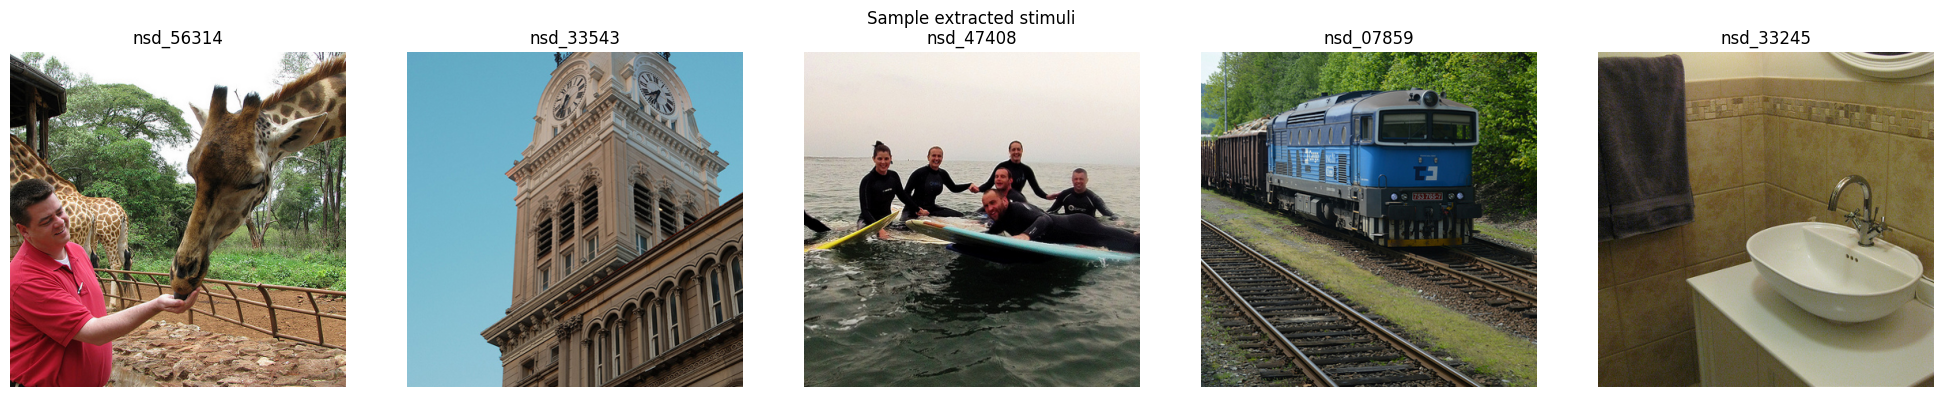

Image size: (425, 425), mode: RGB


In [4]:
# Verify: check file count and spot-check a few images
import matplotlib.pyplot as plt

saved_files = sorted(OUTPUT_DIR.glob('nsd_*.png'))
print(f'PNG files on disk: {len(saved_files)}')
assert len(saved_files) == len(nsd_ids), f'Expected {len(nsd_ids)}, got {len(saved_files)}'

# Display 5 random samples
rng = np.random.default_rng(42)
sample_indices = rng.choice(len(saved_files), 5, replace=False)

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for ax, idx in zip(axes, sample_indices):
    img = Image.open(saved_files[idx])
    ax.imshow(img)
    ax.set_title(saved_files[idx].stem)
    ax.axis('off')
plt.suptitle('Sample extracted stimuli')
plt.tight_layout()
plt.show()

# Verify image dimensions
sample_img = Image.open(saved_files[0])
print(f'Image size: {sample_img.size}, mode: {sample_img.mode}')